# Install Dependencies

In [1]:
!pip install tensorflow==2.10.0

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install tensorflow-gpu==2.10.0

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


# Import Dependencies

In [5]:
#importing standard dependencies

import cv2
import os
import random
import time
import numpy as np
from matplotlib import pyplot as plt

In [6]:
#imporing tensorflow dependencies - Functional API

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


# Set GPU Growth

#### This is to avoid the out of memory error and limit the GPU usage
#### If memory growth is enabled for a PhysicalDevice, the runtime initialization will not allocate all memory on the device.

In [7]:
#check the number of available GPU and also check if tensorflow is detecting it
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [8]:
#getting the details of the GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1352273607483476690
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14436535534586564701
 physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [9]:
#setting memory growth for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# Create folder structure

In [14]:
import tempfile

temp_dir = tempfile.gettempdir() # retrieves the system's temporary directory

temp_dir

'C:\\Users\\utsav\\AppData\\Local\\Temp'

In [17]:
# Setup paths in temp dir
POS_PATH = os.path.join(temp_dir,'data', 'positive')
NEG_PATH = os.path.join(temp_dir,'data', 'negative')
ANC_PATH = os.path.join(temp_dir,'data', 'anchor')

print("Positive path: ",POS_PATH)
print("Negative path: ",NEG_PATH)
print("Anchor path: ",ANC_PATH)

Positive path:  C:\Users\utsav\AppData\Local\Temp\data\positive
Negative path:  C:\Users\utsav\AppData\Local\Temp\data\negative
Anchor path:  C:\Users\utsav\AppData\Local\Temp\data\anchor


In [30]:

# Make the directories
if not os.path.exists(POS_PATH):
    os.makedirs(POS_PATH)
if not os.path.exists(NEG_PATH):
    os.makedirs(NEG_PATH)
if not os.path.exists(ANC_PATH):
    os.makedirs(ANC_PATH)

# Collect Positives,Negatives and Anchors

#### Negatives collection from existing dataset

In [21]:

#Uncompress Tar GZ Labelled Faces in the Wild Dataset

!tar -xf "C:\Users\utsav\Documents\lfw.tgz" --directory "C:\Users\utsav\Documents"

In [33]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir("C:/Users/utsav/Documents/lfw"):
    for file in os.listdir(os.path.join("C:/Users/utsav/Documents/lfw", directory)):
        EX_PATH = os.path.join("C:/Users/utsav/Documents/lfw", directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

#### Positive collection from webcam

In [34]:
# importing uuid library to geenrate unique image names
import uuid

In [ ]:
cap = cv2.VideoCapture(0)

# Set the capture duration to 5 minutes (300 seconds)
capture_duration = 15

# Record start time
start_time = time.time()

while(int(time.time() - start_time) < capture_duration):
    ret, frame = cap.read()

    #to capture only 250x250px to make all images a standard size
    frame = frame[120:120+250,200:200+250,:]

    #to rectify the lateral inversion
    flipped_frame = cv2.flip(frame, 1)

    cv2.waitKey(1)

    # Create the unique file path 
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
    
    # Write out anchor image
    cv2.imwrite(imgname, frame)

    cv2.imshow('Image collection',flipped_frame)
   

cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:929: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


#### Anchor collection from webcam

In [36]:
cap = cv2.VideoCapture(0)

# Set the capture duration to 5 minutes (300 seconds)
capture_duration = 15

# Record start time
start_time = time.time()

while(int(time.time() - start_time) < capture_duration):
    ret, frame = cap.read()

    #to capture only 250x250px to make all images a standard size
    frame = frame[120:120+250,200:200+250,:]

    #to rectify the lateral inversion
    flipped_frame = cv2.flip(frame, 1)

    cv2.waitKey(1)

    # Create the unique file path 
    imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
    
    # Write out anchor image
    cv2.imwrite(imgname, frame)

    cv2.imshow('Image collection',flipped_frame)
   

cap.release()
cv2.destroyAllWindows()

# Data Augmentation

In [56]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [57]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [58]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# Load and Preprocess Images

#### Get images directories

In [59]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [60]:
dir_test = anchor.as_numpy_iterator()

In [61]:
#to check if the iterator is reading all the imaage path
print(dir_test.next())

b'C:\\Users\\utsav\\AppData\\Local\\Temp\\data\\anchor\\fea7b3bc-3550-11f0-8e40-c423607b4a5c.jpg'


#### Preprocessing - Scale and Resize

In [62]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [71]:
img = preprocess(dir_test.next())

In [64]:
img.numpy()

array([[[0.5647059 , 0.6039216 , 0.56078434],
        [0.5710784 , 0.6102941 , 0.56715685],
        [0.5708333 , 0.610049  , 0.56691176],
        ...,
        [0.60563725, 0.6487745 , 0.58504903],
        [0.60612744, 0.6551471 , 0.5855392 ],
        [0.60294116, 0.65392154, 0.5833333 ]],

       [[0.5872549 , 0.6166667 , 0.57254905],
        [0.5828431 , 0.6127451 , 0.5683824 ],
        [0.57230395, 0.6102941 , 0.55857843],
        ...,
        [0.60612744, 0.6522059 , 0.58431375],
        [0.6039216 , 0.65294117, 0.5865196 ],
        [0.59313726, 0.64215684, 0.5764706 ]],

       [[0.57867646, 0.60808825, 0.55808824],
        [0.57916665, 0.60906863, 0.5588235 ],
        [0.5735294 , 0.60490197, 0.5539216 ],
        ...,
        [0.5889706 , 0.6379902 , 0.5715686 ],
        [0.6       , 0.6431373 , 0.5803922 ],
        [0.59705883, 0.6401961 , 0.577451  ]],

       ...,

       [[0.45906863, 0.4629902 , 0.4002451 ],
        [0.47034314, 0.48210785, 0.4120098 ],
        [0.45882353, 0

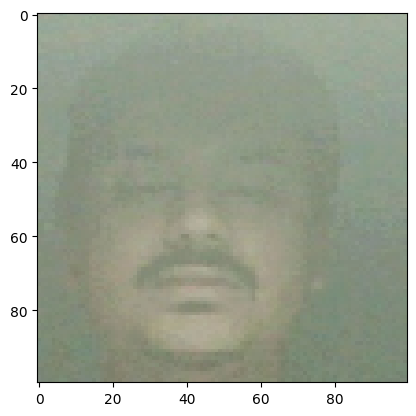

In [72]:
#to check the scaling is working. We will see the image size should be 100x100px
plt.imshow(img)

#### Create Labelled Dataset

In [66]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [67]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [68]:
samples = data.as_numpy_iterator()

In [86]:
example = samples.next()

In [76]:
example

(b'C:\\Users\\utsav\\AppData\\Local\\Temp\\data\\anchor\\f997c20b-3550-11f0-bfad-c423607b4a5c.jpg',
 b'C:\\Users\\utsav\\AppData\\Local\\Temp\\data\\positive\\25657739-3551-11f0-b020-c423607b4a5c.jpg',
 1.0)

#### Build Train and Test Partition

In [73]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [87]:
res = preprocess_twin(*example)

In [79]:
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.6404412 , 0.69534314, 0.60514706],
         [0.6460784 , 0.70098037, 0.6107843 ],
         [0.64436275, 0.6992647 , 0.60906863],
         ...,
         [0.6546569 , 0.68897057, 0.6370098 ],
         [0.6286765 , 0.6718137 , 0.61691177],
         [0.6156863 , 0.654902  , 0.6117647 ]],
 
        [[0.6487745 , 0.69779414, 0.6223039 ],
         [0.6433824 , 0.69436276, 0.61789215],
         [0.6460784 , 0.6985294 , 0.6213235 ],
         ...,
         [0.6362745 , 0.6727941 , 0.62009805],
         [0.62352943, 0.66740197, 0.6125    ],
         [0.61960787, 0.6666667 , 0.61960787]],
 
        [[0.6431373 , 0.6862745 , 0.61960787],
         [0.62916666, 0.68014705, 0.6125    ],
         [0.65      , 0.70465684, 0.6362745 ],
         ...,
         [0.6095588 , 0.65343136, 0.5985294 ],
         [0.6193628 , 0.6661765 , 0.6156863 ],
         [0.63039213, 0.67745095, 0.63039213]],
 
        ...,
 
        [[0.5154412 , 0.57230395

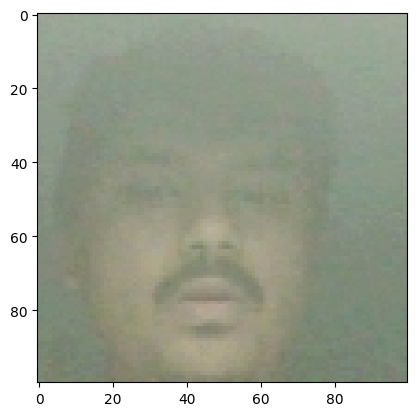

In [88]:
plt.imshow(res[0])

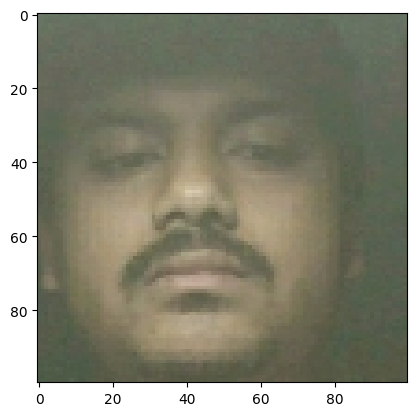

In [89]:
plt.imshow(res[1])

In [ ]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [ ]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)